<a href="https://colab.research.google.com/github/SkinetTeam/Skinet/blob/main/Mask_R_CNN_Nephrology_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Skinet - Segmentation of the Kidney through a Neural nETwork - MEST-C Inference Tool
For more details, visit https://github.com/SkinetTeam/Skinet-MEST-C

ℹ️ **Statistics used to compute MEST-C Score are only available through ```chain``` inference mode !**

## Google Colab Only

Executes only if using this notebook on Google Colab (getting files needed). Errors might appear, do not worry about them. Check that files you wanted to retrieve are in the ```Files``` tab on the left, represented by this icon : image.png

As Google Colab does not refresh the files list quickly, you may want to refresh it manually before checking if the file you are looking for is here, use the following icon to refresh the files list: image.png

For better performance, enable GPU under hardware accelerator: ```Runtime``` > ```Change runtime type``` or  ```Edit``` > ```Notebook Settings``` and then ```'Hardware Accelerator' dropdown list``` > ```GPU```

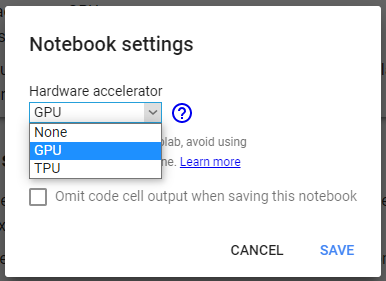

In [ ]:
import re
import sys
import os
IN_COLAB = 'google.colab' in sys.modules
max_px = str(pow(2, 32))
if IN_COLAB:
    !export TF_CPP_MIN_LOG_LEVEL=3
    !export OPENCV_IO_MAX_IMAGE_PIXELS=$max_px
    !export CV_IO_MAX_IMAGE_PIXELS=$max_px
    print("Executing in Google Colab")
    import shutil
    shutil.rmtree('sample_data/', ignore_errors=True)
else:
    os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
    os.environ['OPENCV_IO_MAX_IMAGE_PIXELS']=max_px
    os.environ['CV_IO_MAX_IMAGE_PIXELS']=max_px
    print("Executing locally")

### Retrieving needed files

You can use this cell to update the files that have been downloaded during the same session and that have been updated on GitHub

In [ ]:
if IN_COLAB:
    GITHUB_BRANCH = "v1.0"
    GITHUB_REPO = f"https://raw.githubusercontent.com/SkinetTeam/Skinet-MEST-C/{GITHUB_BRANCH}/"
    files = ['mrcnn/TensorflowDetector.py', 'mrcnn/utils.py', 'mrcnn/visualize.py', 
             'mrcnn/post_processing.py', 'mrcnn/Config.py', 'mrcnn/statistics.py', 
             'mrcnn/datasetDivider.py', 'nephrology.py', 'common_utils.py', "skinet.json"]
    for fileToDownload in files:
        url = GITHUB_REPO + fileToDownload
        !wget -qN $url
        if '/' in fileToDownload:
            os.makedirs(os.path.dirname(fileToDownload), exist_ok=True)
            fileName = os.path.basename(fileToDownload)
            !mv $fileName $fileToDownload

### Connecting to Google Drive

The first time this cell is executed, a link should appear, asking you to accept to give access to files of a google account. 
1.   **Follow the link**;
2.   **Choose the account** you want to link;
3.   **Accept**;
4.   **Copy the key** Google gave you;
5.   **Paste the key in the text field** that appeared below the first link you used,
6.   **Press ENTER**.

In [ ]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

### Retrieving your image(s)

Choose how to get your image(s) from the following list on the right   
Use ```.jpg``` or ```.png``` images only !


In [ ]:
if IN_COLAB:
    howToGetImage = "From Google Drive" #@param ["Upload", "From Google Drive"]

In [ ]:
if IN_COLAB:
    !rm -r images/ || true
    !mkdir -p images
    !mkdir -p images/chain
    !mkdir -p images/cortex
    !mkdir -p images/mest_main

#### By upload

In [ ]:
if IN_COLAB and howToGetImage == "Upload":
    imageType = 'chain' #@param ["chain", "cortex", "mest_main"]
    print("Please upload the image(s) you want to run the inference on, you can upload the corresponding annotations files too.")
    from google.colab import files
    import shutil
    uploaded = files.upload()
    for fileName in uploaded:
        shutil.move(fileName, os.path.join("images", imageType, fileName))

#### By copy from Google Drive

Be sure to customize the 2 variables for Google Colab to be able find your file(s) in Google Drive.
Let's say you have this hierarchy in your Google Drive:
```
Root directory of Google Drive
  ├─── Directory1
  └─── Directory2
       └─── images
            ├─── example1.png
            └─── example2.png
```
1.   ```customPathInDrive``` must represent all the directories between the root directory and your image file. In the example, it would be ```Directory2/images```. Keep it empty if **the file is directly in the root directory** of Google Drive;
2.   ```imageFilePath``` must represent the file you want to upload. In the example, it would be ```example1.png```. It can also be empty if you want to import all the folder's images directly to Google Colab, so in the example, ```example1.png``` and ```example2.png``` would be imported.

Use the text fields available on the right.

In [ ]:
if IN_COLAB and howToGetImage == "From Google Drive":
    imageType = 'chain' #@param ["chain", "cortex", "mest_main"]
    pathToDrive = "/content/drive/MyDrive/"
    customPathInDrive = "" #@param {type:"string"}
    pathToFolder = os.path.join(pathToDrive, customPathInDrive)
    imageFilePath = "" #@param{type:"string"}
    if imageFilePath != "":
        pathToImage = os.path.join(pathToFolder, imageFilePath)
        tempPath = os.path.join("images", imageType, imageFilePath)
        print(f"Copying {pathToImage} to {tempPath}")
        !cp -u $pathToImage $tempPath
    else:
        fileList = os.listdir(pathToFolder)
        for dataFile in fileList:
            if dataFile.split('.')[-1] in ['png', 'jpg']:
                pathToFile = os.path.join(pathToFolder, dataFile)
                tempPath = os.path.join("images", imageType, dataFile)
                print(f"Copying {pathToFile} to {tempPath}")
                !cp -u $pathToFile $tempPath

## Initialization

### Configuration

You will have to open the **Files tab** in the **vertical navigation bar on the left** to see the results appearing. They should be downloaded as a zip file automatically at the end, if it is not the case: save them by right-clicking on each file you want to keep (or the zip file that contains everything).

  - ```mode```: The inference mode to use. Note that ```chain``` will use following modes in the same order: cortex, mest_main, and mest_glom.
  - ```displayMode```: Whether to display every step of an inference, or only AP and statistics.
  
  - ```moveAutoCortexOutputToMainInput```: Whether to move automatically cortex output image to mest_main mode input folder while using cortex as single inference mode.
  
ℹ️ **Statistics used to compute MEST-C Score are only available through ```chain``` inference mode !**

In [ ]:
mode = 'chain' #@param ["chain", "cortex", "mest_main"]
displayMode = "All steps" #@param ["All steps", "Only AP & statistics"]
moveAutoCortexOutputToMainInput = True #@param {type:"boolean"}

### Information

In [ ]:
print(f"Inference Tool in {mode} segmentation mode.")
import nephrology as nephro
images = nephro.listAvailableImage(os.path.join('images', mode))
nb = len(images)
print(f"Found {nb if nb > 0 else 'no'} image{'s' if nb > 1 else ''}{':' if nb > 0 else ''}")
print("\n".join([f" - {image}" for image in images]))

## Inference

In [ ]:
import shutil
shutil.rmtree('data/', ignore_errors=True)
if len(images) > 0:
    try:
        model is None
        if mode != lastMode:
            raise NameError()
    except NameError:
        lastMode = mode
        model = nephro.NephrologyInferenceModel('skinet.json', low_memory=IN_COLAB)
    if mode != "chain":
        model.load(mode=mode)
    model.inference(images, "results/inference/", chainMode=(mode == "chain"), displayOnlyAP=(displayMode == "Only AP & statistics"))

### Moving Fusion files (Colab + Local) and downloading results (Colab only)

In [ ]:
import os
if len(images) > 0:
    lastDir = 'inference'
    remainingPath = "results/"
    lastFoundDir = None
    fileList = os.listdir(remainingPath)
    fileList.sort()
    for resultFolder in fileList:
        if lastDir in resultFolder and os.path.isdir(os.path.join(remainingPath, resultFolder)):
            lastFoundDir = resultFolder
    if lastFoundDir is not None:
        lastFoundDirPath = os.path.join(remainingPath, lastFoundDir)
        if mode == "cortex" and moveAutoCortexOutputToMainInput:
            for imageFolder in os.listdir(lastFoundDirPath):
                imageFolderPath = os.path.join(lastFoundDirPath, imageFolder)
                if os.path.isdir(imageFolderPath):
                    cleanedImagePath = os.path.join(imageFolderPath, imageFolder + "_cleaned.jpg")
                    if os.path.exists(cleanedImagePath):
                            shutil.copy2(cleanedImagePath, os.path.join("images", "mest_main", imageFolder + "_cleaned.jpg"))
        if IN_COLAB:
            zipName = lastFoundDir + '.zip'
            !zip -qr $zipName $lastFoundDirPath
            print("Results can be downloaded on the Files tab on the left")
            print("Zip file name is :", zipName)

This cell may run indefinitely, Google Colab has problem with downloading automatically large files.

In [ ]:
if IN_COLAB and len(images) > 0:
    from google.colab import files
    files.download(zipName)